# Uncertainty Prediction and Evaluation For Regression Neural Networks
In this notebook, we demonstrate uncertainty prediction and evaluation for neural networks.


<br> For evaluation, we will demonstrate four different metrics:
 - Reliability Diagram
 - Spread-Skill Plot
 - Probability Integral Transform (PIT) Diagram
 - Discard Test


<br> This notebook combines work from: <br>
- Barnes, E.A., R.J. Barnes, and N. Gordillo, 2021: Adding uncertainty to neural network regression tasks in the geosciences, *arXiv preprint arXiv:2109.07250.* \
- Brey, S.J., 2021: A package for making and working with probabilistic predictions.  Github, https://github.com/TheClimateCorporation/ensemble/. \
- Lagerquist, R., D. Turner, I. Ebert-Uphoff, J. Stewart, and V. Hagerty, V., 2021: Using Deep Learning to Emulate and Accelerate a Radiative Transfer Model. *Journal of Atmospheric and Oceanic Technology*, <b>38</b>(10), pp.1673-1696, https://doi.org/10.1175/MWR-D-21-0096.1.

## Import Libraries

In [238]:
import copy
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import scipy
import shapely.geometry
import tensorflow as tf
import tensorflow_probability as tfp
import time

from descartes import PolygonPatch
from sklearn.model_selection import train_test_split

## Data Setup
This notebook trains fully-connected neural networks with a single input feature and targets selected from a list.  For demonstration purposes, the user can select targets from six options:

  - Linear Increasing Mean with Normally Distributed Spread (normal)
  - Linear Increasing Mean with Log-Normal Distributed Spread (lognorm)
  - Linear Increasing Mean with Linear Heteroscedastic Spread (hetlin)
  - Linear Decreasing Mean with Non-Linear Heteroscedastic Spread (hetnon)
  - Exponential Increasing Mean with Increasing Spread (gamma)
  - Exponential and Point Mass Distributions (gammap)

In [239]:
DATA_TYPES = ['normal','lognorm','hetlin','hetnon','gamma', 'gammap']

### Create the dataset
First define a function that will create the dataset with the specified characteristics from DATA_TYPES.

In [240]:
# Create the dataset.
def create_dataset(data_type_list=DATA_TYPES,
                   n_data=25000,
                   muMult=2., muOffset=1., 
                   point_mass_frac=0.3, point_mass_value=0.,
                   sigma=0.75,
                   test_fraction=0.2,
                   x_min=0, x_max=10):
  
  # Create x-values using a random uniform distribution
  X_all = np.float32(np.random.uniform(x_min, x_max, n_data))
  X_allNorm = (X_all - X_all.min()) / (X_all.max() - X_all.min())

  # Create y-values using specified distributions
  n_target=len(data_type_list)
  tTitle = []
  Y_all = np.empty((n_data, n_target))
  yTitle = []

  
  mu = muMult * X_all + muOffset

  for t in range(n_target):
      if data_type_list[t] == 'normal':
        Y_all[:, t] = np.random.normal(loc=mu, scale=sigma, size=n_data)
        yTitle.append('Normal Spread')
        tTitle.append('Normal')
      elif data_type_list[t] == 'lognorm':
        sig_a = np.log(1 + (sigma**2 / mu**2))
        mu_a = np.log(mu) - sig_a / 2
        Y_all[:, t] = np.random.lognormal(
            mean=mu_a, sigma=np.sqrt(sig_a), size=n_data)
        yTitle.append('Log-Normal Spread')
        tTitle.append('Log-Normal')
      elif data_type_list[t] == 'hetlin':
        sigma_2 = 0.6 + 0.4 + np.cos(X_allNorm * 3 * np.pi)
        Y_all[:, t] = np.random.normal(loc=mu, scale=sigma_2, size=n_data)
        yTitle.append('Linear Heteroscedastic')
        tTitle.append('Linear')
      elif data_type_list[t] == 'hetnon':
        mu_non = 2.75 * np.sin(X_allNorm * 0.2 * np.pi) - mu
        sigma_2 = 0.6 + 0.4 + np.cos(X_allNorm * 3 * np.pi)
        Y_all[:, t] = np.random.normal(loc=mu_non, scale=sigma_2, size=n_data)
        yTitle.append('Non-Linear Heteroscedastic')
        tTitle.append('Non-Linear')
      elif data_type_list[t] == 'gamma':
        r_gamma = np.array([np.random.gamma(shape=i, scale=i) for i in X_all])
        Y_all[:, t] = np.float32(np.power(X_all, 3.15) + r_gamma * 4.0) / 100.
        yTitle.append('Exponential Distribution')
        tTitle.append('Gamma')
      elif data_type_list[t] == 'gammap':
        r_gamma = np.array([np.random.gamma(shape=i, scale=i) for i in X_all])
        miles = np.float32(np.power(X_all, 3.15) + r_gamma * 4.0) / 100.
        n_pointmass = int(point_mass_frac * n_data)
        replace_ind = np.random.randint(0, n_data, n_pointmass)
        miles[replace_ind] = point_mass_value
        Y_all[:, t] = miles
        yTitle.append('Exponential Point Mass')
        tTitle.append('Point')
      else:
        print("Unknown DATA_TYPE: {}".format(data_type_list[t]))
        Y_all[:, t] = 1.0
        yTitle.append('Constant')
        tTitle.append('Constant')

  if len(X_all.shape) < 2:
      X_all = X_all.reshape(-1, 1)
  X_train, X_test, Y_train, Y_test = train_test_split(
    X_all, Y_all, test_size=test_fraction)
  return X_train, X_test, Y_train, Y_test, yTitle, tTitle

Second, create training and testing data.

In [241]:
x_train, x_test, y_train, y_test, yTitle, tTitle = create_dataset(DATA_TYPES)

### Plot the datasets (if desired)

In [242]:
plotData = True

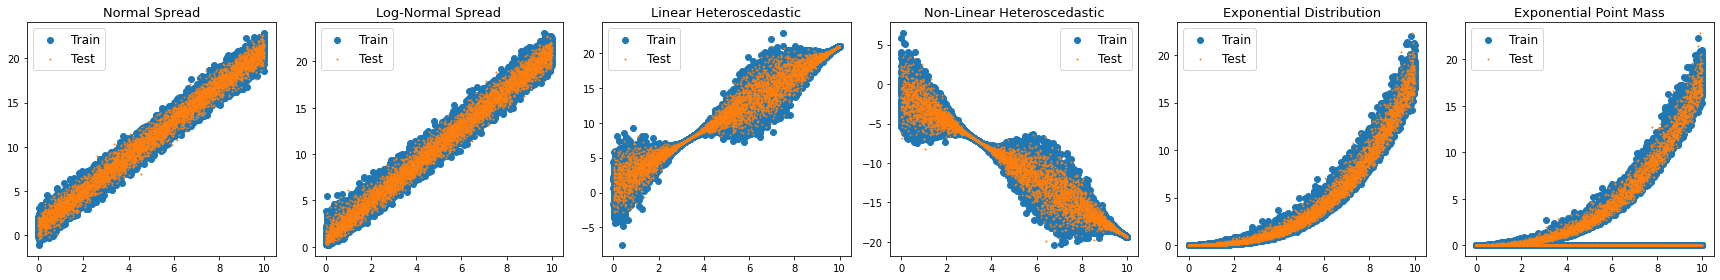

In [243]:
if plotData:
    n_target = len(DATA_TYPES)
    fig, axAll = plt.subplots(1, n_target,
                              figsize=(4 * n_target, 4))

    for i in range(n_target):
        if n_target == 1:
            ax = axAll
        else:
            ax = axAll[i]

        ax.scatter(x_train, y_train[:, i],
                   color='tab:blue', label='Train')
        ax.scatter(x_test, y_test[:, i],
                   color='tab:orange', s=1,
                   label='Test')
        ax.set_title(yTitle[i], fontsize=13)
        ax.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

## Model Setup
To do this, the user has the option to select one of six different model types.  The last four are different methods for quantifying uncertainty (UQ).
 - Mean Absolute Error Loss (mae)
 - Mean Squared Error Loss (mse)
 - UQ Distribution Prediction with a Normal Distribution (uq_normal)
 - UQ Distribution Prediction with the SinH-ArcSinH Distribution (uq_sinh)
 - UQ Continuous Ranked Probability Score (CRPS) Loss Function (crps)
 - UQ Monte-Carlo Dropout
  * MAE Loss (mae_dropout)
  * MSE Loss (mse_dropout)

In [244]:
MODEL_TYPE = 'uq_normal'

### Model Parameters
All of the model options are specified in a dictionary.  These are currently set to defaults that will work for all model type selections.

In [245]:
# Model Options
MC_NTRIALS = 30  # Number of CRPS and Dropout ensemble members 
N_EPOCHS = 150   # Maximum number of epochs to run (model uses early stopping)
STANDARDIZEX = True # Standardize the input features?
STANDARDIZEY = True # Standardize the output targets?
modelOpts = {
    'exRef': 'UQ_Model',
    'network': 'NeuralNetwork',
    'activation_dense': 'relu',
    'batchnorm_flag': False,
    'bias_flag': True,
    'bias_init': 'zeros',
    'bias_reg': None,
    'dropout_flag': False,
    'dropout_dense_last': 0.5,
    'dropout_dense_list': [0.0, 0.1, 0.2],
    'kernel_init': 'glorot_uniform',
    'kernel_reg': None,
    'kernel_reg_lval': 0.01,
    'loss_type': MODEL_TYPE,
    'n_dense_list': [100, 100, 100],
    'seed': None,
    'standardizeX': STANDARDIZEX,
    'standardizeY': STANDARDIZEY,
    'uq_n_members': MC_NTRIALS}
runOpts = {
    'batch_size': 128,
    'epochs': N_EPOCHS,
    'learning_rate': 0.0001,
    'optimizer': 'adam',
    'patience': 4}
expUQ = {'modelOpts': modelOpts,
         'runOpts': runOpts}

### Loss Functions
In order to quantify uncertainty, several methods require specific loss functions, which are defined here.

In [246]:
def loss_crps_sample_score(y_true, y_pred):
    """Calculates the Continuous Ranked Probability Score (CRPS)
    for finite ensemble members.
    This implementation is based on the identity:
    .. math::
        CRPS(F, x) = E_F|X - x| - 1/2 * E_F|X - X'|
    where X and X' denote independent random variables drawn from
    the forecast distribution F, and E_F denotes the expectation
    value under F.

    Following the aproach of
    https://github.com/TheClimateCorporation/properscoring
    for the actual implementation.
    Adapted from http://www.cs.columbia.edu/~blei/

    Reference
    ---------
    Tilmann Gneiting and Adrian E. Raftery (2005).
        Strictly proper scoring rules, prediction, and estimation.
        University of Washington Department of Statistics Technical
        Report no. 463R.
        https://www.stat.washington.edu/research/reports/2004/tr463R.pdf
    """

    # Variable names below reference equation terms in docstring above
    term_one = tf.reduce_mean(tf.abs(
        tf.subtract(y_pred, y_true)), axis=-1)
    term_two = tf.reduce_mean(
        tf.abs(
            tf.subtract(tf.expand_dims(y_pred, -1),
                        tf.expand_dims(y_pred, -2))
        ),
        axis=(-2, -1)
    )
    half = tf.constant(-0.5, dtype=term_two.dtype)
    score = tf.add(term_one, tf.multiply(half, term_two))
    score = tf.reduce_mean(score)
    return score

In [247]:
def loss_crps_sample_score2D(y_true, y_pred):
    """Calculates the Continuous Ranked Probability Score (CRPS)
    for finite ensemble members.
    This implementation is based on the identity:
    .. math::
        CRPS(F, x) = E_F|X - x| - 1/2 * E_F|X - X'|
    where X and X' denote independent random variables drawn from
    the forecast distribution F, and E_F denotes the expectation
    value under F.

    Following the aproach of
    https://github.com/TheClimateCorporation/properscoring
    for the actual implementation.
    Adapted from http://www.cs.columbia.edu/~blei/

    Reference
    ---------
    Tilmann Gneiting and Adrian E. Raftery (2005).
        Strictly proper scoring rules, prediction, and estimation.
        University of Washington Department of Statistics Technical
        Report no. 463R.
        https://www.stat.washington.edu/research/reports/2004/tr463R.pdf

    NOTE: TO GET THIS TO WORK FOR PREDICTING MORE THAN A SINGLE TARGET,
      THE Y_TRUE MUST BE EXPANDED BY A DIMENSION (OF 1 AS A FILLER)
      IN ORDER TO BE COMPATABILE WITH THE Y_PRED FOR THE OPERATIONS.
    """

    # Variable names below reference equation terms in docstring above
    term_one = tf.reduce_mean(tf.abs(
        tf.subtract(y_pred,
                    tf.expand_dims(y_true, -1))), axis=-1)
    term_two = tf.reduce_mean(
        tf.abs(
            tf.subtract(tf.expand_dims(y_pred, -1),
                        tf.expand_dims(y_pred, -2))
        ),
        axis=(-2, -1)
    )
    half = tf.constant(-0.5, dtype=term_two.dtype)
    score = tf.add(term_one, tf.multiply(half, term_two))
    score = tf.reduce_mean(score)
    return score

In [248]:
def loss_uq_normal(y_true, y_pred):
    """
    This is the log-probability loss to calculate uncertainty
    with a normal distribution.
    This form predicts the uncertainty mean and standard deviation
    for a normal distribution.
    From Barnes, Barnes, & Gordillo (2021).
    """

    y_pred64 = tf.cast(y_pred, tf.float64)
    y_true64 = tf.cast(y_true, tf.float64)

    # network prediction of the value
    mu = y_pred64[..., 0]

    # network prediction of uncertainty
    std = tf.math.exp(y_pred64[..., 1])

    # normal distribution defined by N(mu,sigma)
    norm_dist = tfp.distributions.Normal(mu, std)

    # compute the log as -log(p)
    loss = -norm_dist.log_prob(y_true64)

    return tf.reduce_mean(loss)

In [249]:
def loss_uq_sinh(y_true, y_pred):
    """
    This is the log-probability loss to calculate uncertainty
    with a sinh-arcsinh normal distribution.
    This form predicts the uncertainty mean,
    standard deviation (scale),
    skewness and tailweight (tau).
    From Barnes, Barnes, & Gordillo (2021).
    """

    mu = tf.cast(y_pred[..., 0], tf.float64)
    std = tf.math.exp(tf.cast(y_pred[..., 1], tf.float64))
    skew = tf.cast(y_pred[..., 2], tf.float64)
    tau = tf.math.exp(tf.cast(y_pred[..., 3], tf.float64))

    cond_dist = tfp.distributions.SinhArcsinh(
        loc=mu, scale=std, skewness=skew, tailweight=tau)
    loss = -cond_dist.log_prob(tf.cast(y_true, tf.float64))

    return tf.reduce_mean(loss)

### Distribution UQ Helper Functions
Helper functions are required in order to unscale the predictions that predict distribution parameters.  Here we have the helper functions for the normal and sinh-arcsinh distributions. 

In [250]:
def normal_unscale_tf(mu, sigma, YMeans, YStds,
                      nSamples=100,
                      uqLow=2.5, uqHigh=97.5):

    cond_dist = tfp.distributions.Normal(mu, sigma)
    sample_scaled = cond_dist.sample(nSamples).numpy()
    sample = YStds * sample_scaled + YMeans

    pmean = np.mean(sample, axis=0)
    pmedian = np.median(sample, axis=0)
    pstd = np.std(sample, axis=0)
    pmin = np.percentile(sample, uqLow, axis=0)
    pmax = np.percentile(sample, uqHigh, axis=0)

    return pmean, pmedian, pstd, pmin, pmax

In [251]:
def sinh_unscale_tf(mu, sigma, gamma, tau, YMeans, YStds,
                    nSamples=100,
                    uqLow=2.5, uqHigh=97.5):

    cond_dist = tfp.distributions.SinhArcsinh(mu, sigma, gamma, tau)
    sample_scaled = cond_dist.sample(nSamples).numpy()
    sample = YStds * sample_scaled + YMeans

    pmean = np.mean(sample, axis=0)
    pmedian = np.median(sample, axis=0)
    pstd = np.std(sample, axis=0)
    pmin = np.percentile(sample, uqLow, axis=0)
    pmax = np.percentile(sample, uqHigh, axis=0)

    return pmean, pmedian, pstd, pmin, pmax

In [252]:
def _jones_pewsey_P(q):
    """ P_q function from page 764 of [1].
    This is a module private helper function.
    This function will not be called externally.

    Arguments
    ---------
    q : float or double , array like
    Returns
    -------
    P_q : array like of same shape as q.

    Notes
    -----
    * The strange constant 0.25612... is "sqrt(sqrt(e) / (8* pi))"
    computed with a high-precision calculator.
    """

    return 0.25612601391340369863537463 * (
        scipy.special.kv((q + 1) / 2, 0.25)
        + scipy.special.kv((q - 1) / 2, 0.25))

In [253]:
def sinh_mean(mu, sigma, gamma, tau):
    """ The distribution mean.

    Arguments
    ---------
    mu : float or double (batch size x 1) Tensor
        The location parameter.
    sigma : float or double (batch size x 1) Tensor
        The scale parameter. Must be strictly positive.
        Must be the same shape and dtype as mu.
    gamma : float or double (batch size x 1) Tensor
        The skewness parameter.
        Must be the same shape and dtype as mu.
    tau : float or double (batch size x 1) Tensor
        The tail - weight parameter.
        Must be strictly positive.
        Must be the same shape and dtype as mu.

    NOTE: I HAVE CONVERTED THESE TO NUMPY.
          TO GET BACK TO TENSORS REPLACE "np."
             WITH "tf.math."

    Returns
    -------
    x: float or double (batch size x 1) Tensor.
    The computed distribution mean values .
    """
    evX = np.sinh(gamma / tau) * _jones_pewsey_P(1.0 / tau)
    return mu + sigma * evX

In [254]:
def sinh_median(mu, sigma, gamma, tau):
    """ The distribution median.

    Arguments
    ---------
    mu : float or double (batch size x 1) Tensor
        The location parameter.
    sigma : float or double (batch size x 1) Tensor
        The scale parameter.
        Must be strictly positive.
        Must be the same shape and dtype as mu.
    gamma : float or double (batch size x 1) Tensor
        The skewness parameter.
        Must be the same shape and dtype as mu.
    tau : float or double ( batch size x 1) Tensor
        The tail-weight parameter.
        Must be strictly positive.
        Must be the same shape and dtype as mu.

    Returns
    -------
    x : float or double (batch size x 1) Tensor.
        The computed distribution mean values .

    Notes
    -----
    * This code uses the basic formula :
        E(a*X + b) = a*E(X) + b
    * The E(X) is computed using the moment equation given
        on page 764 of [1].
    """
    return mu + sigma * np.sinh(gamma / tau)

In [255]:
def sinh_stddev(mu, sigma, gamma, tau):
    """ The distribution standard deviation.

    Arguments
    ---------
    mu : float or double (batch size x 1) Tensor
        The location parameter.
    sigma : float or double ( batch size x 1) Tensor
        The scale parameter.
        Must be strictly positive.
        Must be the same shape and dtype as mu.
    gamma : float or double (batch size x 1) Tensor
        The skewness parameter.
        Must be the same shape and dtype as mu.
    tau : float or double (batch size x 1) Tensor
        The tail-weight parameter.
        Must be strictly positive.
        Must be the same shape and dtype as mu.

    NOTE: I HAVE CONVERTED THESE TO NUMPY.
          TO GET BACK TO TENSORS REPLACE "np."
             WITH "tf.math."

    Returns
    -------
    x : float or double (batch size x 1) Tensor.
        The computed distribution mean values.
    """
    return np.sqrt(sinh_variance(mu, sigma, gamma, tau))

In [256]:
def sinh_variance(mu, sigma, gamma, tau):
    """ The distribution variance.

    Arguments
    ---------
    mu : float or double (batch size x 1) Tensor
        The location parameter.
    sigma : float or double (batch size x 1) Tensor
        The scale parameter.
        Must be strictly positive.
        Must be the same shape and dtype as mu.
    gamma : float or double (batch size x 1) Tensor
        The skewness parameter.
        Must be the same shape and dtype as mu.
    tau : float or double ( batch size x 1) Tensor
        The tail-weight parameter.
        Must be strictly positive.
        Must be the same shape and dtype as mu.

    NOTE: I HAVE CONVERTED THESE TO NUMPY.
          TO GET BACK TO TENSORS REPLACE "np."
             WITH "tf.math."

    Returns
    -------
    x : float or double (batch size x 1) Tensor.
    The computed distribution mean values .

    Notes
    -----
    * This code uses two basic formulas:
        var(X) = E(X^2) - (E(X))^2
        var(a*X + b) = a^2 * var(X)
    * The E(X) and E(X^2) are computed using the
        moment equations given on page 764 of [1].
    """
    evX = np.sinh(gamma / tau) * _jones_pewsey_P(1.0 / tau)
    evX2 = (np.cosh(2 * gamma / tau)
            * _jones_pewsey_P(2.0 / tau) - 1.0) / 2
    return np.square(sigma) * (evX2 - np.square(evX))

In [257]:
def sinh_min(mu, sigma, gamma, tau,
             nsamples=10000,
             uqLow=2.5,
             YMeans=None, YStds=None):

    cond_dist = tfp.distributions.SinhArcsinh(mu, sigma, gamma, tau)
    sample = cond_dist.sample(nsamples).numpy()
    if (YMeans is not None) and (YStds is not None):
        sample = sample * YStds + YMeans

    return np.percentile(sample, uqLow, axis=0)

In [258]:
def sinh_max(mu, sigma, gamma, tau,
             nsamples=10000,
             uqHigh=97.5,
             YMeans=None, YStds=None):

    cond_dist = tfp.distributions.SinhArcsinh(mu, sigma, gamma, tau)
    sample = cond_dist.sample(nsamples).numpy()
    if (YMeans is not None) and (YStds is not None):
        sample = sample * YStds + YMeans
    return np.percentile(sample, uqHigh, axis=0)

### Setup Helper Functions
Setup helper routines are defined in order to allow for various options of optimizer and loss function.

In [259]:
def setup_loss(loss_f, n_outputs=1):
    """Return loss function and metrics from string option."""

    metrics = []
    if loss_f == 'mae':
        loss = tf.keras.losses.MAE
    elif loss_f == 'mae_dropout':
        loss = tf.keras.losses.MAE
    elif loss_f == 'crps':
        if n_outputs < 2:
            loss = loss_crps_sample_score
        else:
            loss = loss_crps_sample_score2D
    elif loss_f == 'mse':
        loss = tf.keras.losses.MSE
    elif loss_f == 'mse_dropout':
        loss = tf.keras.losses.MSE
    elif loss_f == 'uq_normal':
        loss = loss_uq_normal
    elif loss_f == 'uq_sinh':
        loss = loss_uq_sinh
    else:
        print("UNKNOWN LOSS FUNCTION, USING MSE")
        loss = tf.keras.losses.MSE
    return loss, metrics

In [260]:
def setup_optimizer(method, learning_rate):
    """Return optimizer from string options."""
    if method == 'sgd':
        algo = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif method == 'adam':
        algo = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif method == 'adagrad':
        algo = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif method == 'rmsprop':
        algo = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif method == 'adadelta':
        algo = tf.keras.optimizers.Adadelta(
            learning_rate=learning_rate)
    elif method == 'nadam':
        algo = tf.keras.optimizers.Nadam(
            learning_rate=learning_rate)
    else:
        raise Exception(
            "train: method={method} not a valid optimizer.")
    return algo

### Model Class Code
Define a NeuralNetwork class that will build, compile, train, and run the model.  The class combines all of the routines for the various uncertainty methods and loss functions so that the basic functions can all be called in a similar fashion. 

In [261]:
class NeuralNetwork():
    def __init__(self, n_inputs, n_outputs,
                 modelOpts):

        erStr = "NeuralNetwork Error:"

        tf.keras.backend.clear_session()

        dropout = modelOpts['dropout_flag']
        dropout_last = modelOpts['dropout_dense_last']
        dropout_list = modelOpts['dropout_dense_list']
        loss_type = modelOpts['loss_type']
        n_hiddens_list = modelOpts['n_dense_list']
        uq_n_members = modelOpts['uq_n_members']

        if not isinstance(n_hiddens_list, list):
            print("{} n_hiddens_list must be a list".format(erStr))
            print("    Using Simple Network With No Hidden Layers.")
            n_hiddens_list = []

        if 'dropout' in loss_type:
            dropout = True
        if dropout:
            if len(dropout_list) != len(n_hiddens_list):
                print("{} {}".format(
                    "dropout_list and n_hiddens_list must have same length",
                    erStr))
                defaultDropout = 0.1
                print("   Using Default Dropout Of {}".format(defaultDropout))
                dropout_list = []
                for _ in n_hiddens_list:
                    dropout_list.append(defaultDropout)

        self.history = None
        self.loss_type = loss_type
        self.n_hiddens_list = n_hiddens_list
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.training_time = None
        self.uq_n_members = uq_n_members

        self.XStandardize = modelOpts['standardizeX']
        self.Xmeans = None
        self.Xstds = None
        self.Xmax = None
        self.Xmin = None

        self.YStandardize = modelOpts['standardizeY']
        self.Ymeans = None
        self.Ystds = None
        self.Ymax = None
        self.Ymin = None

        bias_init = modelOpts['bias_init']
        if bias_init == 'random':
            bias_init = tf.keras.initializers.RandomNormal(
                            seed=modelOpts['seed'])

        kernel_init = modelOpts['kernel_init']
        if kernel_init == 'random':
            kernel_init = tf.keras.initializers.RandomNormal(
                            seed=modelOpts['seed'])

        kernel_reg = modelOpts['kernel_reg']
        kernel_reg_lval = modelOpts['kernel_reg_lval']
        if kernel_reg == 'L1' or kernel_reg == 'l1':
            kernel_reg = tf.keras.regularizers.L1(kernel_reg_lval)
        elif kernel_reg == 'L2' or kernel_reg == 'l2':
            kernel_reg = tf.keras.regularizers.L2(kernel_reg_lval)

        # Setup Initial and Hidden Layers
        X = Z = tf.keras.Input(shape=(n_inputs,))
        nLayers = len(n_hiddens_list)
        for i in range(nLayers):
            if 'dropout' in loss_type:
                Z = tf.keras.layers.Dropout(
                    dropout_list[i])(Z, training=True)
            elif dropout and dropout_list[i] > 0.0:
                Z = tf.keras.layers.Dropout(dropout_list[i])(Z)

            Z = tf.keras.layers.Dense(
                n_hiddens_list[i],
                activation=modelOpts['activation_dense'],
                use_bias=modelOpts['bias_flag'],
                bias_initializer=bias_init,
                bias_regularizer=modelOpts['bias_reg'],
                kernel_initializer=kernel_init,
                kernel_regularizer=kernel_reg)(Z)
            if modelOpts['batchnorm_flag']:
                Z = tf.keras.layers.BatchNormalization()(Z)

        # Setup Output Layer
        if 'crps' in loss_type:
            if dropout and dropout_last > 0.0:
                Z = tf.keras.layers.Dropout(dropout_last)(Z)
            if n_outputs < 2:
                Y = tf.keras.layers.Dense(
                    uq_n_members,
                    kernel_regularizer=kernel_reg,
                    name="ensemble_members")(Z)
            else:
                Y = tf.keras.layers.Dense(
                    n_outputs,
                    kernel_regularizer=kernel_reg)(Z)
                Y = tf.expand_dims(Y, axis=-1)

                for _ in range(1, uq_n_members):
                    outputT = tf.keras.layers.Dense(
                        n_outputs,
                        kernel_regularizer=kernel_reg)(Z)
                    Y = tf.keras.layers.concatenate(
                        (tf.expand_dims(outputT, axis=-1), Y),
                        axis=-1)

        elif 'dropout' in loss_type:
            if dropout_last > 0.0:
                Z = tf.keras.layers.Dropout(dropout_last)(Z, training=True)
            Y = tf.keras.layers.Dense(
                n_outputs,
                kernel_regularizer=kernel_reg,
                name="output")(Z)

        elif 'normal' in loss_type:
            mu_unit = tf.keras.layers.Dense(
                n_outputs, activation="linear",
                use_bias=True,
                bias_initializer=bias_init,
                kernel_initializer=kernel_init,
                name="mu_unit")(Z)
            logsigma_unit = tf.keras.layers.Dense(
                n_outputs, activation="linear",
                use_bias=True,
                bias_initializer=tf.keras.initializers.Zeros(),
                kernel_initializer=tf.keras.initializers.Zeros(),
                name="logsigma_unit")(Z)
            Y = tf.keras.layers.concatenate(
                (tf.expand_dims(mu_unit, axis=2),
                 tf.expand_dims(logsigma_unit, axis=2)),
                axis=2, name="output")

        elif 'sinh' in loss_type:
            mu_unit = tf.keras.layers.Dense(
                n_outputs, activation="linear",
                use_bias=True,
                bias_initializer=bias_init,
                kernel_initializer=kernel_init,
                name="mu_unit")(Z)
            logsigma_unit = tf.keras.layers.Dense(
                n_outputs, activation="linear",
                use_bias=True,
                bias_initializer=tf.keras.initializers.Zeros(),
                kernel_initializer=tf.keras.initializers.Zeros(),
                name="logsigma_unit")(Z)
            skew_unit = tf.keras.layers.Dense(
                n_outputs, activation="linear",
                use_bias=True,
                bias_initializer=tf.keras.initializers.Zeros(),
                kernel_initializer=tf.keras.initializers.Zeros(),
                name="skew_unit")(Z)
            logtau_unit = tf.keras.layers.Dense(
                n_outputs, activation="linear",
                use_bias=True,
                bias_initializer=tf.keras.initializers.Zeros(),
                kernel_initializer=tf.keras.initializers.Zeros(),
                name="logtau_unit")(Z)
            Y = tf.keras.layers.concatenate(
                (tf.expand_dims(mu_unit, axis=2),
                 tf.expand_dims(logsigma_unit, axis=2),
                 tf.expand_dims(skew_unit, axis=2),
                 tf.expand_dims(logtau_unit, axis=2)),
                axis=2, name="output")

        else:
            Y = tf.keras.layers.Dense(
                n_outputs,
                kernel_regularizer=kernel_reg,
                name="output")(Z)

        self.model = tf.keras.Model(
            inputs=X, outputs=Y, name=modelOpts['exRef'])
        print("{} setup with {} inputs and {} outputs".format(
            type(self).__name__, self.n_inputs, self.n_outputs))

    def __repr__(self):
        str1 = f'{type(self).__name__}'
        str2 = "\n  n_inputs: {}, n_outputs: {}".\
            format(self.n_inputs, self.n_outputs)
        str3 = "\n  n_hiddens: {}, loss_type: {}".\
            format(self.n_hiddens_list, self.loss_type)
        if self.history:
            str4 = "\n  Training loss is {:.4f} in {:.3f} s.".\
                format(self.history['loss'][-1],
                       self.training_time)
        else:
            str4 = '\n  Network is not trained.'
        return str1 + str2 + str3 + str4

    def _setup_standardize(self, X, Y):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1

        if self.Ymeans is None:
            if len(Y.shape) == 3:
                YHere = Y[..., 0]
            else:
                YHere = Y
            self.Ymeans = YHere.mean(axis=0)
            self.Ystds = YHere.std(axis=0)
            self.Yconstant = self.Ystds == 0
            self.YstdsFixed = copy.copy(self.Ystds)
            self.YstdsFixed[self.Yconstant] = 1

    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[..., self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _standardizeY(self, Y):
        if len(Y.shape) == 3:
            YHere = Y[..., 0]
        else:
            YHere = Y
        result = (YHere - self.Ymeans) / self.YstdsFixed
        result[..., self.Yconstant] = 0.0

        if len(Y.shape) == 3:
            result = np.concatenate(
                (np.expand_dims(result, axis=2),
                 Y[..., 1:]), axis=2)

        return result

    def _unstandardizeY(self, Ys):
        return self.Ystds * Ys + self.Ymeans

    def compile(self, runOpts):
        """Compile Fully-Connected NN."""

        self.batch_size = runOpts['batch_size']
        self.epochs = runOpts['epochs']
        self.patience = runOpts['patience']
        algo = setup_optimizer(runOpts['optimizer'],
                                   runOpts['learning_rate'])
        loss, metrics = setup_loss(
            self.loss_type,
            n_outputs=self.n_outputs)
        self.model.compile(optimizer=algo, loss=loss,
                           metrics=metrics)

    def train(self, X, T,
              batch_size=None,
              epochs=None,
              patience=None,
              validation=None,
              verbose=False):
        """Use Keras Functional API to train model"""

        if batch_size is None:
            batch_size = self.batch_size
        if epochs is None:
            epochs = self.epochs
        if patience is None:
            patience = self.patience

        if len(X.shape) < 2:
            X = X.reshape((-1, 1))
        if len(T.shape) < 2:
            T = T.reshape((-1, 1))

        self._setup_standardize(X, T)
        if self.XStandardize:
            X = self._standardizeX(X)
        if self.YStandardize:
            T = self._standardizeY(T)

        if validation is not None:
            try:
                XV = validation[0]
                if len(XV.shape) < 2:
                    XV = XV.reshape((-1, 1))

                TV = validation[1]
                if len(TV.shape) < 2:
                    TV = TV.reshape((-1, 1))

                if self.XStandardize:
                    XV = self._standardizeX(XV)
                if self.YStandardize:
                    TV = self._standardizeY(TV)
                validation = (XV, TV)

            except Exception:
                raise TypeError(
                    'validation must have shape: (X, T)')

        if validation is not None:
            callback = [tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', min_delta=0.0,
                patience=patience,
                verbose=1, mode='auto',
                restore_best_weights=True)]
        else:
            callback = []

        start_time = time.time()
        self.history = self.model.fit(X, T,
                                      batch_size=batch_size,
                                      epochs=epochs,
                                      callbacks=callback,
                                      validation_data=validation,
                                      verbose=0).history
        self.training_time = time.time() - start_time
        return self

    def use(self, X, returnType='uq'):

        # Set to error logging after model is trained
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

        if len(X.shape) < 2:
            X = X.reshape((-1, 1))
        if self.XStandardize:
            X = self._standardizeX(X)

        if 'crps' in self.loss_type:
            preds = self.model.predict(X)
            if self.YStandardize:
                for i in range(self.uq_n_members):
                    preds[..., i] = self._unstandardizeY(preds[..., i])

            if returnType == 'uq':
                return np.median(preds, axis=-1), preds.std(axis=-1)
            elif returnType == 'uq3':
                return np.mean(preds, axis=-1), np.std(preds, axis=-1), \
                    np.median(pred, axis=-1)
            elif returnType == 'uq4':
                return preds.mean(axis=-1), preds.std(axis=-1), \
                    preds.min(axis=-1), preds.max(axis=-1)
            elif returnType == 'mc':
                return preds
            else:
                return np.median(preds, axis=-1)

        elif 'dropout' in self.loss_type:
            nTry = self.uq_n_members
            preds = np.concatenate(
                [np.expand_dims(self.model.predict(X), axis=-1)
                    for _ in range(nTry)], axis=-1)

            if self.YStandardize:
                for i in range(self.uq_n_members):
                    preds[..., i] = self._unstandardizeY(preds[..., i])

            if returnType == 'uq':
                return preds.mean(axis=-1), preds.std(axis=-1)
            elif returnType == 'uq3':
                return preds.mean(axis=-1), preds.std(axis=-1), \
                  np.median(preds, axis=-1)
            elif returnType == 'uq4':
                return preds.mean(axis=-1), preds.std(axis=-1), \
                    preds.min(axis=-1), preds.max(axis=-1)
            elif returnType == 'mc':
                return preds
            else:
                return preds.mean(axis=-1)

        elif 'normal' in self.loss_type:
            if returnType == 'mc':
                return None

            if self.YStandardize:
              if self.Ystds is None:
                print("{} Missing Ystds.".format(erStr))
              if self.Ymeans is None:
                print("{} Missing Ymeans.".format(erStr))

            pvals = self.model.predict(X)
            pmean = pvals[..., 0]
            pstd = np.exp(pvals[..., 1])

            if self.YStandardize:
              pmean, pmedian, pstd, pmin, pmax = normal_unscale_tf(
                  pmean, pstd, self.Ymeans, self.Ystds)
            else:
              pmean = pmean
              pmedian = None
              pstd = None
              pmin = None
              pmax = None

            if returnType == 'uq':
                return pmean, pstd
            elif returnType == 'uq3':
                return pmean, pstd, pmedian
            elif returnType == 'uq4':
                return pmedian, pstd, pmin, pmax
            elif returnType == 'params':
                pvals = np.concatenate(
                    [np.expand_dims(pmean, axis=2),
                     np.expand_dims(pstd, axis=2)], axis=2)
                return pvals
            else:
                return pmean

        elif 'sinh' in self.loss_type:
            if returnType == 'mc':
                return None

            pvals = self.model.predict(X)
            mu = pvals[..., 0]
            sigma = np.exp(pvals[..., 1])
            gamma = pvals[..., 2]
            tau = np.exp(pvals[..., 3])

            if returnType == 'params':
                pvals[..., 1] = sigma
                pvals[..., 3] = tau
                return pvals

            if self.YStandardize:
                pmean, pmedian, pstd, pmin, pmax = sinh_unscale_tf(
                        mu, sigma, gamma, tau,
                        self.Ymeans, self.Ystds)
            else:
                pmean = sinh_mean(mu, sigma, gamma, tau)
                pmedian = sinh_median(mu, sigma, gamma, tau)
                pstd = sinh_stddev(mu, sigma, gamma, tau)
                pmin = sinh_min(mu, sigma, gamma, tau)
                pmax = sinh_max(mu, sigma, gamma, tau)

            if returnType == 'params':
                return pvals
            elif returnType == 'uq':
                return pmedian, pstd
            elif returnType == 'uq3':
                return pmean, pstd, pmedian
            elif returnType == 'uq4':
                return pmedian, pstd, pmin, pmax
            else:
                return pmedian

        else:
            preds = self.model.predict(X)
            if self.YStandardize:
                preds = self._unstandardizeY(preds)
            if returnType == 'mc':
              return None
            elif returnType == 'uq':
                return preds, None
            elif returnType == 'uq3':
                return preds, None, None
            elif returnType == 'uq4':
                return preds, None, None, None
            else:
                return preds

## Model Build and Training

In [262]:
# Build and compile model
n_inputs = x_train.shape[-1]
n_outputs = y_train.shape[-1]
uq_nnet = NeuralNetwork(n_inputs, n_outputs, modelOpts)
uq_nnet.compile(runOpts)

NeuralNetwork setup with 1 inputs and 6 outputs


In [263]:
# Show model summary
showSummary = True
if showSummary:
  uq_nnet.model.summary()

Model: "UQ_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 100)          200         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 100)          10100       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 100)          10100       ['dense_1[0][0]']                
                                                                                           

In [264]:
# Train the model
uq_nnet.train(x_train, y_train, validation=(x_test, y_test))

Restoring model weights from the end of the best epoch: 70.
Epoch 74: early stopping


NeuralNetwork
  n_inputs: 1, n_outputs: 6
  n_hiddens: [100, 100, 100], loss_type: uq_normal
  Training loss is -0.7577 in 30.918 s.

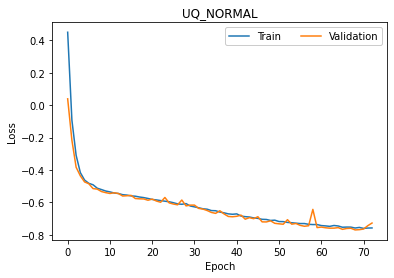

In [265]:
# Plot the loss
plotLoss = True
if plotLoss:
    histDict = uq_nnet.history
    trLoss = histDict['loss'][1:]
    try:
        valLoss = histDict['val_loss'][1:]
    except KeyError:
        valLoss = None

    _, ax = plt.subplots()
    ax.plot(np.asarray(trLoss), label='Train')
    if valLoss is not None:
        ax.plot(np.asarray(valLoss), label='Validation')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(fancybox=True, framealpha=1.0, loc='upper right',
                   ncol=2)
    plt.title(MODEL_TYPE.upper())
    plt.show()

## Evaluation
In order to evaluate the model, let's create predictions over the range of testing data so that we can create line plots.  <br>
- For ensemble approaches, we obtain the predictions for all of the ensemble members (pred_span).  If the model does not have ensemble members, then None is returned. 
- For all, we obtain the prediction mean (pred_mean) and the standard deviation the model determined for uncertainty quantification (pred_std).  If the model does not quantify uncertainty, then pred_std is None.
- For all, we obtain the test predictions and standard deviation matching the x-test values.

In [266]:
x_span = np.expand_dims(np.linspace(
    np.min(x_train), np.max(x_train), 1000), 1)
pred_span = uq_nnet.use(x_span, returnType='mc')
pred_mean, pred_std, pred_median = uq_nnet.use(x_span, returnType='uq3')
pred_test_mean, pred_test_std = uq_nnet.use(x_test, returnType='uq')

### Plot the test data and predictions

In [267]:
plotPredictions = True

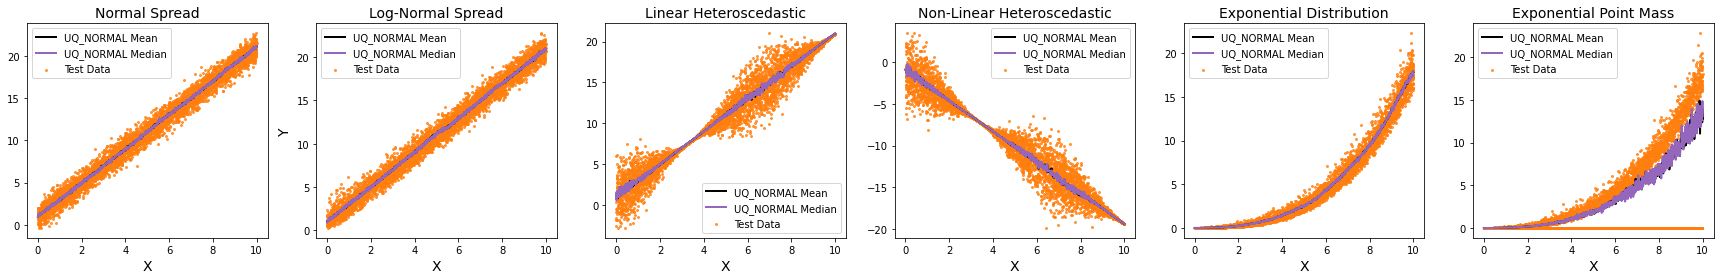

In [268]:
if plotPredictions:
    dataColor = 'tab:orange'
    dataSize = 4
    ensAlpha = 0.3
    ensColor = 'tab:blue'
    meanColor = 'black'
    medianColor = 'tab:purple'
    mLineWidth = 2

    myFontSize=14
    myLabel = MODEL_TYPE.upper()
    n_target = len(DATA_TYPES)
    fig, axAll = plt.subplots(1, n_target,
                              figsize=(4 * n_target, 4))

    for i in range(n_target):
        if n_target == 1:
            ax = axAll
        else:
            ax = axAll[i]

        # test data
        ax.scatter(x_test, y_test[:, i], color=dataColor,
                alpha=0.75, label='Test Data',
                s=dataSize)

        # predicted mean
        ax.plot(x_span, pred_mean[:, i], c=meanColor,
             linewidth=mLineWidth, label=myLabel + ' Mean')

        # predicted median
        if pred_median is not None:
          ax.plot(x_span, pred_median[:, i], c=medianColor,
                linewidth=mLineWidth, label=myLabel + ' Median')
        
        # Plot each member of the ensemble models
        if pred_span is not None:
          for i_ens in np.arange(0, uq_nnet.uq_n_members):
            if i_ens == 0:
              ax.plot(x_span, pred_span[:, i, i_ens],
                       alpha=ensAlpha, c=ensColor,
                       label=myLabel + ' Member')
            else:
              ax.plot(x_span, pred_span[:, i, i_ens],
                       alpha=ensAlpha, c=ensColor)

        # add legend to plot
        ax.legend()
        ax.set_xlabel("X", fontsize=myFontSize)
        if i == 1:
          ax.set_ylabel("Y", fontsize=myFontSize)
        ax.set_title(yTitle[i], fontsize=myFontSize)

    plt.tight_layout()
    plt.show()

### Plot the test data, predictions, and uncertainty

In [269]:
plotUQ = True

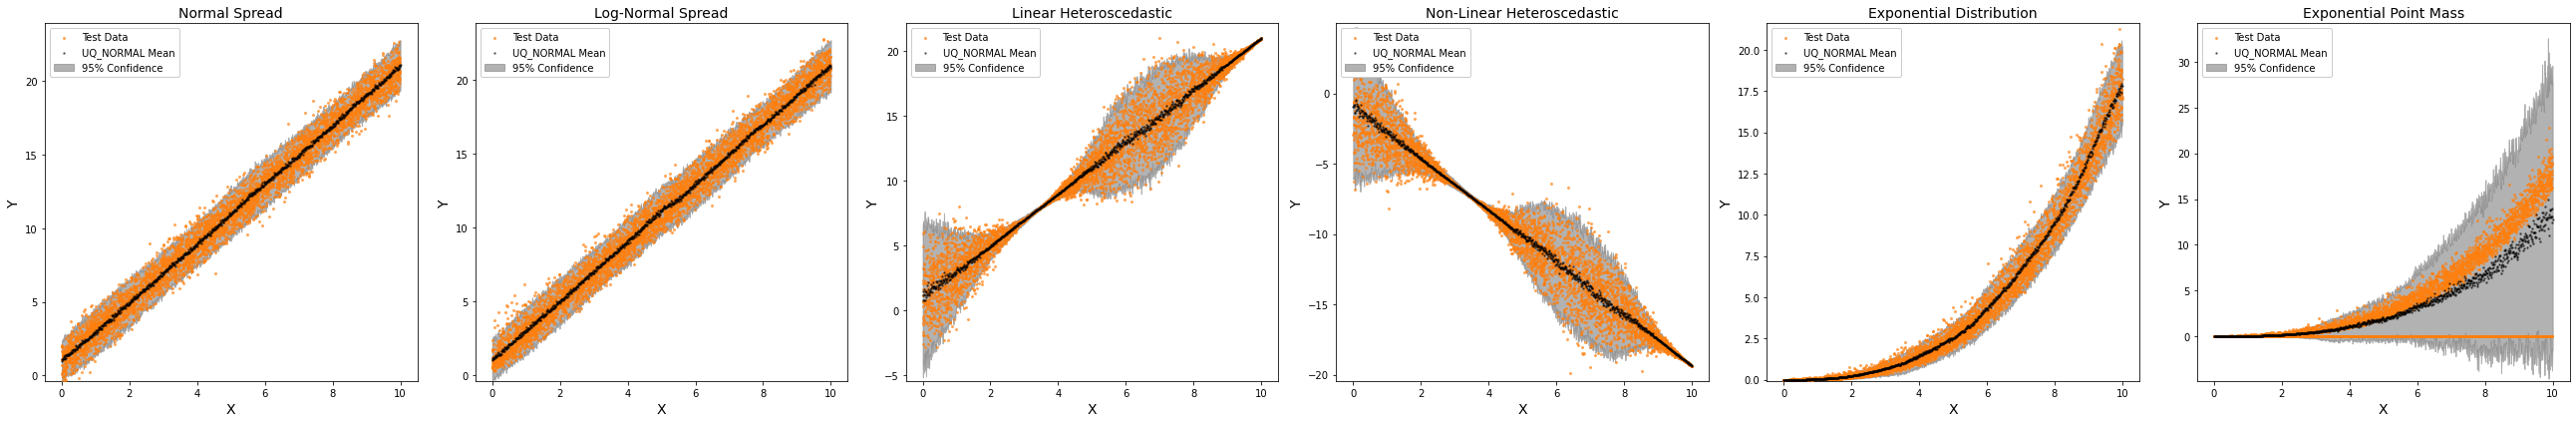

In [270]:
if plotUQ and pred_test_std is not None:
    dataColor = 'tab:orange'
    dataSize = 4
    ensAlpha = 0.3
    ensColor = 'tab:blue'
    meanColor = 'black'
    medianColor = 'tab:purple'
    mLineWidth = 2
    mSize = 2

    myFontSize=14
    myLabel = MODEL_TYPE.upper()

    _, axAll = plt.subplots(1, n_target, figsize=(6 * n_target, 6))
    for i in range(n_target):
        if n_target == 1:
            ax = axAll
        else:
            ax = axAll[i]

        # model values
        pred_mean1 = pred_mean[:, i]
        pred_std1 = pred_std[:, i]
        pred_down1 = pred_mean1 - 1.96 * pred_std1
        pred_up1 = pred_mean1 + 1.96 * pred_std1
        ymin1 = np.min(pred_down1)
        ymax1 = np.max(pred_up1)
        ylims = [ymin1 * 1.05, ymax1 * 1.05]

        # plot data
        ax.scatter(x_test, y_test[:, i], 
                   alpha=0.6, color=dataColor,
                   s=dataSize, label="Test Data",
                   zorder=5)
        
        # plot mean and standard deviations
        ax.scatter(x_span[:, 0], pred_mean1, 
                   alpha=0.5, color=meanColor,
                   label=myLabel + " Mean",
                   s=mSize, zorder=15)
        ax.fill_between(x_span[:, 0], pred_up1, pred_down1,
                        alpha=0.6, color='gray',
                        label="95% Confidence",
                        zorder=0)

        myTitle = yTitle[i]
        ax.set_title(myTitle, fontsize=myFontSize)
        ax.set_xlabel('X', fontsize=myFontSize)
        ax.set_ylabel('Y', fontsize=myFontSize)
        ax.set_ylim(ylims)
        ax.legend(fancybox=True, framealpha=1.0,
                  loc='upper left')

    plt.tight_layout()
    plt.show()


### Reliability Diagram
The reliability diagram is a way to evaluate the central predictions from the model.  For regression tasks:
- x-axis: central predicted value (in this case the mean) grouped into bins
- y-axis: corresponding true value for the predicted points

#### Generic Helper Functions
These are generic functions to do some basic tasks necessary for the calculation of the points in the reliability diagram.

In [271]:
def create_contours(minVal, maxVal, nContours, match=False):
    if match:
        xVal = np.max([np.abs(minVal), np.abs(maxVal)])
        # if nContours % 2 == 1:
        #    nContours += 1
        interval = 2 * xVal / (nContours - 1)
    else:
        interval = (maxVal - minVal) / (nContours - 1)
    contours = np.empty((nContours))
    for i in range(nContours):
        contours[i] = minVal + i * interval
    return contours

In [272]:
def get_edges(xvals):
    cmid = [xvals[j] - (xvals[j + 1] - xvals[j]) * 0.5
            for j in range(len(xvals) - 1)]
    c1 = [xvals[-1] - (xvals[-1] - xvals[-2]) * 0.5]
    c2 = [xvals[-1] + (xvals[-1] - xvals[-2]) * 0.5]
    return np.array(cmid + c1 + c2)

In [273]:
def get_histogram(var, bins=10, density=False, weights=None):
    counts, bin_edges = np.histogram(
        var, bins=bins, density=density, weights=weights)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return counts, bin_centers

In [274]:
def get_min_max(var1, var2):
    myMin = np.min([var1.min(), var2.min()])
    myMax = np.max([var1.max(), var2.max()])
    return myMin, myMax

In [275]:
def list_to_int(input_list):
    out_list = []
    for ele in input_list:
        out_list.append(int(ele))
    return out_list

#### Reliability Plot Helper Functions
These are helper functions for creating the figure, including plotting the figure background and insets.

In [276]:
def _get_positive_skill_area(mean_value_in_training, min_value_in_plot,
                             max_value_in_plot):
    """Returns positive-skill area (where BSS > 0) for attributes diagram.

    :param mean_value_in_training: Mean of target variable in training data.
    :param min_value_in_plot: Minimum value in plot (for both x- and y-axes).
    :param max_value_in_plot: Max value in plot (for both x- and y-axes).
    :return: x_coords_left: length-5 numpy array of x-coordinates for left part
        of positive-skill area.
    :return: y_coords_left: Same but for y-coordinates.
    :return: x_coords_right: length-5 numpy array of x-coordinates for right
        part of positive-skill area.
    :return: y_coords_right: Same but for y-coordinates.
    """

    x_coords_left = np.array([
        min_value_in_plot, mean_value_in_training, mean_value_in_training,
        min_value_in_plot, min_value_in_plot
    ])
    y_coords_left = np.array([
        min_value_in_plot, min_value_in_plot, mean_value_in_training,
        (min_value_in_plot + mean_value_in_training) / 2, min_value_in_plot
    ])

    x_coords_right = np.array([
        mean_value_in_training, max_value_in_plot, max_value_in_plot,
        mean_value_in_training, mean_value_in_training
    ])
    y_coords_right = np.array([
        mean_value_in_training,
        (max_value_in_plot + mean_value_in_training) / 2,
        max_value_in_plot, max_value_in_plot, mean_value_in_training
    ])

    return x_coords_left, y_coords_left, x_coords_right, y_coords_right


In [277]:
def _get_zero_skill_line(mean_value_in_training, min_value_in_plot,
                         max_value_in_plot):
    """Returns zero-skill line (where BSS = 0) for attributes diagram.

    :param mean_value_in_training: Mean of target variable in training data.
    :param min_value_in_plot: Minimum value in plot (for both x- and y-axes).
    :param max_value_in_plot: Max value in plot (for both x- and y-axes).
    :return: x_coords: length-2 numpy array of x-coordinates.
    :return: y_coords: Same but for y-coordinates.
    """

    x_coords = np.array([min_value_in_plot, max_value_in_plot], dtype=float)
    y_coords = 0.5 * (mean_value_in_training + x_coords)

    return x_coords, y_coords

In [278]:
def _plot_attr_diagram_background(
        axes_object, mean_value_in_training, min_value_in_plot,
        max_value_in_plot,
        climo_width=2.,
        climo_color=np.full(3, 152. / 255),
        positive_skill_opacity=0.2,
        zero_skill_color=np.array([31, 120, 180], dtype=float) / 255.,
        zero_skill_width=2):
    """Plots background (reference lines and polygons) of attributes diagram.

    :param axes_object: Will plot on these axes (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    :param mean_value_in_training: Mean of target variable in training data.
    :param min_value_in_plot: Minimum value in plot (for both x- and y-axes).
    :param max_value_in_plot: Max value in plot (for both x- and y-axes).
    """

    x_coords_left, y_coords_left, x_coords_right, y_coords_right = (
        _get_positive_skill_area(
            mean_value_in_training=mean_value_in_training,
            min_value_in_plot=min_value_in_plot,
            max_value_in_plot=max_value_in_plot))

    skill_area_colour = colors.to_rgba(zero_skill_color,
                                       positive_skill_opacity)

    this_list = _vertex_arrays_to_list(
        vertex_x_coords=x_coords_left, vertex_y_coords=y_coords_left)
    
    left_polygon_object = shapely.geometry.Polygon(shell=this_list)
    left_patch_object = PolygonPatch(
        left_polygon_object, lw=0, ec=skill_area_colour, fc=skill_area_colour
    )
    axes_object.add_patch(left_patch_object)

    this_list = _vertex_arrays_to_list(
        vertex_x_coords=x_coords_right, vertex_y_coords=y_coords_right
    )
    right_polygon_object = shapely.geometry.Polygon(shell=this_list)
    right_patch_object = PolygonPatch(
        right_polygon_object, lw=0, ec=skill_area_colour, fc=skill_area_colour
    )
    axes_object.add_patch(right_patch_object)

    no_skill_x_coords, no_skill_y_coords = _get_zero_skill_line(
        mean_value_in_training=mean_value_in_training,
        min_value_in_plot=min_value_in_plot,
        max_value_in_plot=max_value_in_plot)

    axes_object.plot(
        no_skill_x_coords, no_skill_y_coords, color=zero_skill_color,
        linestyle='solid', linewidth=zero_skill_width)

    climo_x_coords = np.full(2, mean_value_in_training)
    climo_y_coords = np.array([min_value_in_plot, max_value_in_plot])
    axes_object.plot(
        climo_x_coords, climo_y_coords, color=climo_color,
        linestyle='dashed', linewidth=climo_width)

    axes_object.plot(
        climo_y_coords, climo_x_coords, color=climo_color,
        linestyle='dashed', linewidth=climo_width)

In [279]:
def _plot_inset_histogram(
        figure_object, bin_centers, bin_counts,
        bar_align='center',
        bar_colour=np.array([228, 26, 28], dtype=float) / 255,
        bar_edge=np.full(3, 0.),
        bar_width=2.,
        font_size=14,
        has_predictions=False,
        shift_x=0.0,
        shift_y=0.0,
        tick_vals=None,
        title=None):
    """Plots histogram as inset in attributes diagram."""

    bin_frequencies = bin_counts.astype(float) / np.sum(bin_counts)

    if has_predictions:
        inset_axes_object = figure_object.add_axes(
            [0.675 + shift_x, 0.225 + shift_y, 0.2, 0.2])
    else:
        inset_axes_object = figure_object.add_axes(
            [0.22 + shift_x, 0.625 + shift_y, 0.2, 0.2])

    inset_axes_object.bar(bin_centers, bin_frequencies,
                          align=bar_align,
                          color=bar_colour,
                          edgecolor=bar_edge,
                          width=bar_width)
    inset_axes_object.set_ylim(bottom=0.)

    if tick_vals is None:
        x_tick_values = bin_centers
        x_tick_labels = [str(int(b)) for b in bin_centers]
        inset_axes_object.set_xticks(x_tick_values)
        inset_axes_object.set_xticklabels(x_tick_labels)
    else:
        inset_axes_object.set_xticks(tick_vals)

    for this_tick_object in inset_axes_object.xaxis.get_major_ticks():
        this_tick_object.label.set_fontsize(font_size)
        this_tick_object.label.set_rotation('vertical')

    for this_tick_object in inset_axes_object.yaxis.get_major_ticks():
        this_tick_object.label.set_fontsize(font_size)

    if title is None:
        title = 'Pred Freq' if has_predictions else 'Obs Freq'
    inset_axes_object.set_title(
        title,
        fontsize=font_size)

In [280]:
def _plot_reliability_curve(
        axes_object,
        mean_predictions,
        mean_observations,
        min_value_to_plot,
        max_value_to_plot,
        labelx='Prediction Frequency',
        labely='Conditional Observed Frequency',
        line_colour=np.full(3, 152. / 255),
        line_label=None,
        line_style='solid',
        line_width=2.,
        marker='x',
        marker_size=10,
        ref_color=np.full(3, 152. / 255),
        ref_width=2.,
        tick_vals=None):
    """Plots reliability curve.

    B = number of bins

    :param axes_object: Will plot on these axes (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    :param mean_predictions: length-B numpy array of mean predicted values.
    :param mean_observations: length-B numpy array of mean observed values.
    :param min_value_to_plot: See doc for `plot_attributes_diagram`.
    :param max_value_to_plot: Same.
    :param line_colour: Line colour (in any format accepted by matplotlib).
    :param line_style: Line style (in any format accepted by matplotlib).
    :param line_width: Line width (in any format accepted by matplotlib).
    :return: main_line_handle: Handle for main line (reliability curve).
    """

    perfect_x_coords = np.array([min_value_to_plot, max_value_to_plot])
    perfect_y_coords = np.array([min_value_to_plot, max_value_to_plot])

    axes_object.plot(
        perfect_x_coords, perfect_y_coords,
        color=ref_color,
        linestyle='dashed',
        linewidth=ref_width)

    nan_flags = np.logical_or(
        np.isnan(mean_predictions), np.isnan(mean_observations)
    )

    if np.all(nan_flags):
        main_line_handle = None
    else:
        real_indices = np.where(np.invert(nan_flags))[0]

        main_line_handle = axes_object.plot(
            mean_predictions[real_indices],
            mean_observations[real_indices],
            color=line_colour,
            label=line_label,
            linestyle=line_style,
            linewidth=line_width,
            marker=marker,
            markersize=marker_size)[0]

    axes_object.set_xlabel(labelx)
    axes_object.set_ylabel(labely)
    axes_object.set_xlim(min_value_to_plot, max_value_to_plot)
    axes_object.set_ylim(min_value_to_plot, max_value_to_plot)

    if tick_vals is not None:
        axes_object.xaxis.set_ticks(tick_vals)
        axes_object.yaxis.set_ticks(tick_vals)

    return main_line_handle

In [281]:
def _vertex_arrays_to_list(vertex_x_coords, vertex_y_coords):
    """Converts vertices of simple polygon from two arrays to one list.

    V = number of vertices

    :param vertex_x_coords: length-V numpy array of x-coordinates.
    :param vertex_y_coords: length-V numpy array of y-coordinates.
    :return: vertex_coords_as_list: length-V list, where each element is an
        (x, y) tuple.
    """

    num_vertices = len(vertex_x_coords)
    vertex_coords_as_list = []

    for i in range(num_vertices):
        vertex_coords_as_list.append((vertex_x_coords[i], vertex_y_coords[i]))

    return vertex_coords_as_list

In [282]:
def get_reliability_points(y_true, y_pred,
                                  aDict={},
                                  min_val=None,
                                  max_val=None,
                                  nBins=12,
                                  nTicks=6,
                                  y_train=None):

    nTargets = y_true.shape[-1]

    if min_val is None:
        minFlag = True
        min_val = np.empty((nTargets))
    else:
        minFlag = False

    if max_val is None:
        maxFlag = True
        max_val = np.empty((nTargets))
    else:
        maxFlag = False

    if minFlag or maxFlag:
        for tg in range(nTargets):
            min_val_temp, max_val_temp = get_min_max(
                y_pred[..., tg], y_true[..., tg])

            if minFlag:
                min_val[tg] = min_val_temp
            if maxFlag:
                max_val[tg] = max_val_temp

    mean_val = np.empty((nTargets))
    obs_bins = np.empty((nBins, nTargets))
    obs_counts = np.empty((nBins, nTargets))
    obs_vals = np.empty((nBins, nTargets))
    pred_bins = np.empty((nBins, nTargets))
    pred_counts = np.empty((nBins, nTargets))
    pred_vals = np.empty((nBins, nTargets))
    tick_vals = np.empty((nTicks, nTargets))

    for tg in range(nTargets):
        y_trueH = y_true[..., tg].reshape(-1)
        y_predH = y_pred[..., tg].reshape(-1)
        if y_train is not None:
            y_trainH = y_train[..., tg].reshape(-1)
            mean_val[tg] = y_trainH.mean()
        else:
            mean_val[tg] = y_trueH.mean()

        bin_centers = create_contours(min_val[tg], max_val[tg], nBins)
        bin_edges = get_edges(bin_centers)

        for i in range(nBins):
            gref = np.logical_and(y_predH >= bin_edges[i],
                                  y_predH < bin_edges[i + 1])
            pred_vals[i, tg] = np.mean(y_predH[gref])
            obs_vals[i, tg] = np.mean(y_trueH[gref])

        obs_counts[:, tg], obs_bins[:, tg] = get_histogram(
            y_trueH, bins=bin_edges)
        pred_counts[:, tg], pred_bins[:, tg] = get_histogram(
            y_predH, bins=bin_edges)
        tick_vals[:, tg] = list_to_int(
            np.linspace(min_val[tg], max_val[tg], nTicks))

    aDict['attributes_min_val'] = min_val
    aDict['attributes_max_val'] = max_val
    aDict['attributes_mean_val'] = mean_val
    aDict['attributes_obs_bins'] = obs_bins
    aDict['attributes_obs_counts'] = obs_counts
    aDict['attributes_obs_vals'] = obs_vals
    aDict['attributes_pred_bins'] = pred_bins
    aDict['attributes_pred_counts'] = pred_counts
    aDict['attributes_pred_vals'] = pred_vals
    aDict['attributes_tick_vals'] = tick_vals
    return aDict

In [283]:
def plot_reliability_diagram(
        predProb, obsProb,
        axes_object=None,
        fig_object=None,
        hist_width=2.,
        labelx='Prediction Frequency',
        labely='Conditional Observed Frequency',
        line_color=np.array([228, 26, 28], dtype=float) / 255,
        line_style='solid',
        line_width=2.,
        mean_val=0.5,
        min_val=0.,
        max_val=1.,
        obs_centers=None,
        obs_counts=None,
        pred_centers=None,
        pred_counts=None,
        save_file='',
        show_background=True,
        show_thresholds=True,
        thresholds=None,
        tick_vals=None,
        title='',
        verbose=True):
    """Plots reliability diagram."""

    if fig_object is None or axes_object is None:
        showFig = True
        fig_object, axes_object = plt.subplots(1, 1, figsize=(6, 6))
    else:
        showFig = False

    if show_background:
        _plot_attr_diagram_background(
            axes_object=axes_object,
            mean_value_in_training=mean_val,
            min_value_in_plot=min_val,
            max_value_in_plot=max_val)

    if pred_counts is not None and pred_centers is not None:
        _plot_inset_histogram(
            figure_object=fig_object,
            bar_width=hist_width,
            bin_centers=pred_centers,
            bin_counts=pred_counts,
            has_predictions=True,
            bar_colour=line_color,
            tick_vals=tick_vals)

    if obs_counts is not None and obs_centers is not None:
        _plot_inset_histogram(
            figure_object=fig_object,
            bar_width=hist_width,
            bin_centers=obs_centers,
            bin_counts=obs_counts,
            has_predictions=False,
            bar_colour=line_color,
            tick_vals=tick_vals)

    rel_handle = _plot_reliability_curve(
        axes_object=axes_object,
        mean_predictions=predProb,
        mean_observations=obsProb,
        min_value_to_plot=min_val,
        max_value_to_plot=max_val,
        labelx=labelx,
        labely=labely,
        line_colour=line_color,
        line_style=line_style,
        line_width=line_width,
        tick_vals=tick_vals)

    if show_thresholds and thresholds is not None:
        for i in range(len(thresholds)):
            axes_object.text(
                predProb[i],
                obsProb[i],
                str(int(thresholds[i])) + '  ',
                color=rel_handle.get_color(),
                verticalalignment='bottom',
                horizontalalignment='right',
                fontsize=12)

    if title:
        axes_object.set_title(title)

    if showFig:
        if save_file:
            plt.savefig(save_file, bbox_inches='tight')
            if verbose:
                print("Saved File: {}".format(save_file))
        else:
            plt.show()
        plt.close()
        return
    else:
        return rel_handle

In [284]:
def plot_reliability_diagram_dict(
        aDict,
        bar_color='tab:blue',
        bar_edges='tab:blue',
        labelx='Prediction',
        labely='Conditional Mean Observation',
        legend_show=True,
        legend_size=13,
        line_color=None,
        line_label=None,
        line_style='solid',
        line_width=2,
        marker='x',
        marker_size=8,
        plot_obs_hist=True,
        plot_pred_hist=False,
        save_file='',
        show_background=True,
        targetNum=0,
        title='',
        units='',
        verbose=True):
    """Plots regression reliability diagram."""

    if line_color is None:
        line_color = ['tab:orange', 'seagreen',
                   'tab:purple', 'deeppink',
                   'tab:olive', 'tab:cyan',
                   'tab:brown', 'tab:gray']

    expList = list(aDict.keys())
    refDict = aDict[expList[0]]
    tg = targetNum

    if units:
        labelx += f' [{units}]'
        labely += f' [{units}]'

    fig_object, axes_object = plt.subplots(1, 1, figsize=(6, 6))

    if show_background:
        _plot_attr_diagram_background(
            axes_object=axes_object,
            mean_value_in_training=refDict['attributes_mean_val'][tg],
            min_value_in_plot=refDict['attributes_min_val'][tg],
            max_value_in_plot=refDict['attributes_max_val'][tg])

    if plot_obs_hist:
        _plot_inset_histogram(
            figure_object=fig_object,
            bin_centers=refDict['attributes_obs_bins'][:, tg],
            bin_counts=refDict['attributes_obs_counts'][:, tg],
            has_predictions=False,
            bar_colour=bar_color,
            bar_edge=bar_edges,
            tick_vals=refDict['attributes_tick_vals'][:, tg])

    if plot_pred_hist:
        _plot_inset_histogram(
            figure_object=fig_object,
            bin_centers=refDict['attributes_pred_bins'][:, tg],
            bin_counts=refDict['attributes_pred_counts'][:, tg],
            has_predictions=True,
            bar_colour=bar_color,
            tick_vals=refDict['attributes_tick_vals'][:, tg])

    # ... get the minimum and maximum for the axes
    min_val = 999.
    max_val = -999.
    for exp in expList:
        eDict = aDict[exp]
        minH = eDict['attributes_min_val'][tg]
        if minH < min_val:
          min_val = minH

        maxH = eDict['attributes_max_val'][tg]
        if maxH > max_val:
          max_val = maxH 

    # ... add the reliability curves
    iExp = 0
    for exp in expList:
        eDict = aDict[exp]
        obs_vals = eDict['attributes_obs_vals'][:, tg]
        pred_vals = eDict['attributes_pred_vals'][:, tg]

        if line_label is not None:
            lineLabel = line_label[iExp]
        else:
            lineLabel = None

        _plot_reliability_curve(
            axes_object=axes_object,
            mean_predictions=pred_vals,
            mean_observations=obs_vals,
            min_value_to_plot=min_val,
            max_value_to_plot=max_val,
            labelx=labelx,
            labely=labely,
            line_colour=line_color[iExp],
            line_label=lineLabel,
            line_style=line_style,
            line_width=line_width,
            marker=marker,
            marker_size=marker_size)

        iExp += 1

    if legend_show:
        axes_object.legend(fontsize=legend_size, loc='lower right')
    if title:
        axes_object.set_title(title)

    if save_file:
        plt.savefig(save_file, bbox_inches='tight')
        if verbose:
            print("Saved File: {}".format(save_file))
    else:
        plt.show()
    plt.close()
    return

#### Individual Reliability Plots
Create individual reliability plots (if requested).

In [285]:
plotReliabilityI = True

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


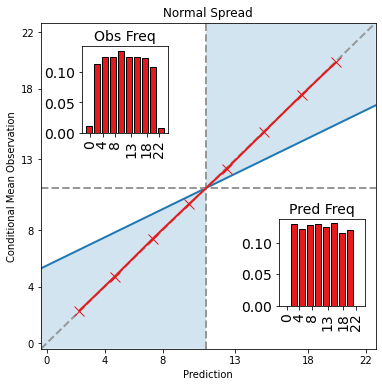

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


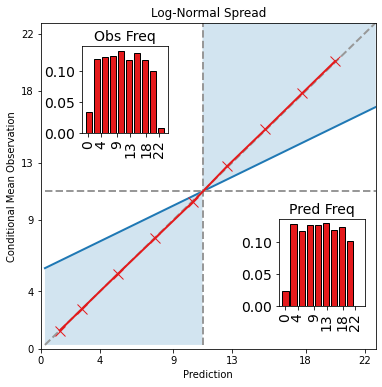

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


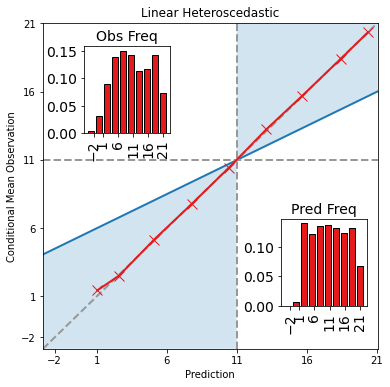

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


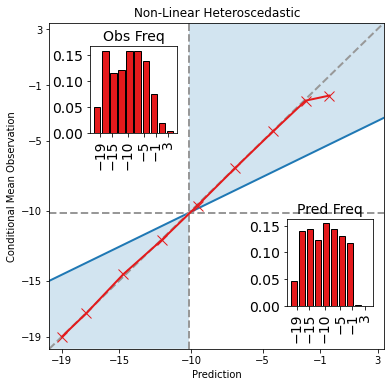

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


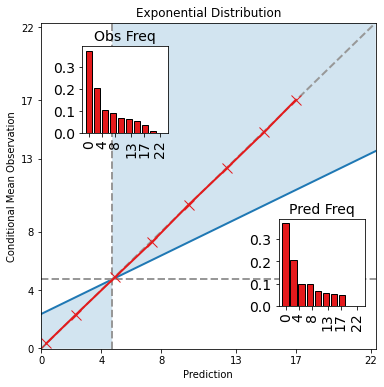

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


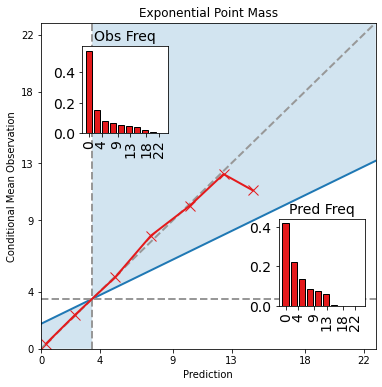

In [286]:
if plotReliabilityI:

    nBins = 10
    n_target = len(DATA_TYPES)
    for i in range(n_target):

        # model values
        y_pred = pred_test_mean[..., i].reshape(-1)
        y_true = y_test[..., i].reshape(-1)
        y_mean = y_train[..., i].mean()

        min_val, max_val = get_min_max(y_pred, y_true)
        bin_centers = create_contours(min_val, max_val, nBins)
        bin_edges = get_edges(bin_centers)

        pred_vals = np.empty((nBins))
        obs_vals = np.empty((nBins))
        for ib in range(nBins):
          gref = np.logical_and(y_pred >= bin_edges[ib],
                                y_pred < bin_edges[ib + 1])
          pred_vals[ib] = np.mean(y_pred[gref])
          obs_vals[ib] = np.mean(y_true[gref])

        obs_counts, bins_center = get_histogram(y_true, bins=bin_edges)
        pred_counts, bins_center = get_histogram(y_pred, bins=bin_edges)
        if np.abs(min_val) > 1000 or np.abs(max_val) > 1000:
          hist_width=100
        elif np.abs(min_val) > 100 or np.abs(max_val) > 100:
          hist_width=10
        else:
          hist_width=2

        tick_vals = list_to_int(np.linspace(min_val, max_val, 6))
        plot_reliability_diagram(
            pred_vals, obs_vals,
            hist_width=hist_width,
            labelx='Prediction',
            labely='Conditional Mean Observation',
            mean_val=y_mean,
            min_val=min_val, max_val=max_val,
            obs_centers=bins_center,
            obs_counts=obs_counts,
            pred_centers=bins_center,
            pred_counts=pred_counts,
            tick_vals=tick_vals,
            title=yTitle[i])


#### Combined Reliability Diagram
In some cases, it might be desirable to evaluate several central predictions together on a single figure.  Here we will plot a single reliability diagram for all targets.  Most often you'd probably want to do this with common observations and different experiment predictions; however, since all of our targets have a similar range of values, we can do this here in order to more easily compare how the model performs on the different test sets.  Since the mean value and counts have changed, we will not plot the background nor the histograms.

In [287]:
plotReliability = True

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


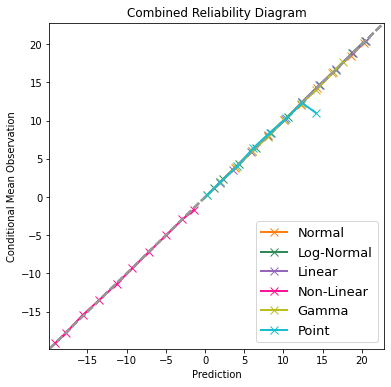

In [288]:
if plotReliability:
  n_target = len(DATA_TYPES)
  rDict = {}
  spread_bins = None
  for tg in range(n_target):
    eDict = {}
    eDict = get_reliability_points(
        y_test[..., tg:tg + 1],
        pred_test_mean[..., tg:tg + 1],
        aDict=eDict)
    rDict[tTitle[tg]] = eDict

  plot_reliability_diagram_dict(
      rDict, line_label=tTitle,
      plot_obs_hist=False, plot_pred_hist=False,
      show_background=False,
      title='Combined Reliability Diagram')

### Spread-Skill Diagram
The spread-skill diagram is a way to evaluate the uncertainty predictions, by plotting how the uncertainty matches the actual error.

#### Spread-Skill Calculation Functions

In [289]:
def rmse(A, B):
    return np.sqrt(np.mean((A - B)**2))

In [290]:
def calculate_spread_skill(ytrue, ymean, ystd,
                           bins=None, nBins=20,
                           returnBins=False):

    model_rmse = rmse(ytrue, ymean)
    minBin = np.min([model_rmse.min(), ystd.min()])
    maxBin = np.ceil(np.max([model_rmse.max(), ystd.max()]))

    if not bins:
        bins = np.round(np.linspace(minBin, maxBin, nBins + 1), 1)
    else:
        nBins = len(bins) - 1

    error = np.empty((nBins))
    spread = np.empty((nBins))
    for i in range(nBins):
        refs = np.logical_and(ystd >= bins[i], ystd < bins[i + 1])
        if np.count_nonzero(refs) > 0:
            ytrueBin = ytrue[refs]
            ymeanBin = ymean[refs]
            error[i] = rmse(ytrueBin, ymeanBin)
            spread[i] = np.mean(ystd[refs])
        else:
            spread[i] = -999
            error[i] = -999

    if returnBins:
        return spread, error, bins
    else:
        return spread, error

In [291]:
def get_spread_skill_points(y_true, y_pred, y_std,
                            nBins=12,
                            sDict={},
                            spread_bins=None,
                            spread_last=None):

    nTargets = y_true.shape[-1]

    if spread_bins is None:
        spread_bins_start = []
        for tg in range(nTargets):
          spread_bins_start.append(None)
        binFlag = True
    else:
        binFlag = False
        spread_bins_start = spread_bins.copy()

    spread_bins = []
    spread_counts = []
    spread_vals = []
    error_vals = []
    for tg in range(nTargets):
        spread_valsH, error_valsH, spread_binsH = \
            calculate_spread_skill(
                y_true[..., tg], y_pred[..., tg], y_std[..., tg],
                bins=spread_bins_start[tg], nBins=nBins,
                returnBins=True)
        if spread_last is not None:
            spread_valsH[-1] = spread_last[tg]
        spread_countsH, _ = get_histogram(
            y_std, bins=spread_binsH)

        if binFlag:
            spread_bins.append(list(spread_binsH))
        spread_counts.append(spread_countsH)
        spread_vals.append(spread_valsH)
        error_vals.append(error_valsH)

    sDict['ss_error_vals'] = error_vals
    sDict['ss_spread_bins'] = spread_bins
    sDict['ss_spread_counts'] = spread_counts
    sDict['ss_spread_vals'] = spread_vals
    return sDict

In [292]:
def list_pull_valid(list1, list2=None,
                    badVal=-999):

    refs = []
    for i in range(len(list1)):
        if list1[i] > badVal:
            refs.append(i)

    if list2 is not None:
        return list1[refs], list2[refs]
    else:
        return list1[refs]

#### Spread-Skill Helper Functions

In [293]:
def _plot_inset_counts(
        figure_object, bin_centers, bin_counts,
        line_colour=None,
        line_width=2.,
        has_predictions=False,
        hist_font_size=14,
        marker='x',
        shift_x=0.0,
        shift_y=0.0,
        tick_vals=None,
        tick_vals_set=False,
        title=None):
    """Plots histogram as inset in attributes diagram."""

    if line_colour is None:
      line_colour = ['tab:orange', 'seagreen',
                   'tab:purple', 'deeppink',
                   'tab:olive', 'tab:cyan',
                   'tab:brown', 'tab:gray']

    if has_predictions:
        inset_axes_object = figure_object.add_axes(
            [0.675 + shift_x, 0.225 + shift_y, 0.2, 0.2])
    else:
        inset_axes_object = figure_object.add_axes(
            [0.22 + shift_x, 0.625 + shift_y, 0.2, 0.2])

    for i in range(len(bin_centers)):
        bin_centersH, bin_valsH = list_pull_valid(
            bin_centers[i], bin_counts[i])
        bin_valsH = np.array(bin_valsH)
        bin_freqsH = bin_valsH / bin_valsH.sum()

        inset_axes_object.plot(
            bin_centersH, bin_freqsH,
            color=line_colour[i],
            marker=marker,
            linewidth=line_width)

    inset_axes_object.set_ylim(bottom=0.)

    if tick_vals_set:
      if tick_vals is None:
          x_tick_values = bin_centersH
          x_tick_labels = [str(int(b)) for b in bin_centersH]
          inset_axes_object.set_xticks(x_tick_values)
          inset_axes_object.set_xticklabels(x_tick_labels)
      else:
          inset_axes_object.set_xticks(tick_vals)

    for this_tick_object in inset_axes_object.xaxis.get_major_ticks():
        this_tick_object.label.set_fontsize(hist_font_size)
        this_tick_object.label.set_rotation('vertical')

    for this_tick_object in inset_axes_object.yaxis.get_major_ticks():
        this_tick_object.label.set_fontsize(hist_font_size)

    if title is None:
        title = 'Pred Freq' if has_predictions else 'Obs Freq'
    inset_axes_object.set_title(
        title,
        fontsize=hist_font_size)

In [294]:
def _save_figure(fileName, fig, dpi=200):
    """Save a figure (e.g. png or eps)"""

    myType = fileName[-3:]
    if myType not in ['png', 'eps']:
        print("Expecting to save a png or eps file.")
    else:
        plt.savefig(fileName, bbox_inches="tight", format=myType, dpi=dpi)
        print("Saved File: {}".format(fileName))

    return

In [295]:
def _set_plot_fonts_ax(ax, plotFontSize=20):
    for item in ([ax.xaxis.label, ax.yaxis.label]
                 + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(plotFontSize)

In [296]:
def plot_spread_skill_dict(sDict,
                           figSize=(6, 6),
                           fontSize=18,
                           legend_show=True,
                           legend_loc='lower right',
                           legend_size=10,
                           labelx='Spread (Uncertainty)',
                           labely='Skill (RMSE)',
                           lim_min=0.,
                           lim_max=None,
                           line_color=None,
                           line_label=None,
                           line_width=2.,
                           plot_hist=False,
                           save_file='',
                           shiftx=0.0,
                           shifty=0.0,
                           spread_ticks=None,
                           targetNum=0,
                           title='Spread-Skill Plot',
                           units=''):

    expList = list(sDict.keys())

    if line_color is None:
      line_color = ['tab:orange', 'seagreen',
                   'tab:purple', 'deeppink',
                   'tab:olive', 'tab:cyan',
                   'tab:brown', 'tab:gray']
    if units:
        labelx = labelx + ' [' + units + ']'
        labely = labely + ' [' + units + ']'

    if lim_max is None:
        lim_max = 0.
        for exp in expList:
            eDict = sDict[exp]
            error_vals = eDict['ss_error_vals'][targetNum]
            spread_vals = eDict['ss_spread_vals'][targetNum]
            lim_maxH = np.max([spread_vals.max(), error_vals.max()]) * 1.1
            if lim_maxH > lim_max:
                lim_max = lim_maxH
    lims = [lim_min, lim_max]

    fig = plt.figure(figsize=figSize)
    ax = fig.add_subplot(1, 1, 1)

    iExp = 0
    spread_counts = []
    spread_bins = []
    for exp in expList:
        eDict = sDict[exp]
        errorTP = list_pull_valid(eDict['ss_error_vals'][targetNum])
        spread_vals, spread_counts_exp = list_pull_valid(
            eDict['ss_spread_vals'][targetNum],
            eDict['ss_spread_counts'][targetNum])

        if line_label is not None:
            lineLabel = line_label[iExp]
        else:
            lineLabel = None

        ax.plot(spread_vals, errorTP, 'x-',
                color=line_color[iExp],
                label=lineLabel,
                linewidth=line_width)
        ax.plot(lims, lims,
                alpha=0.4, color='black')

        if plot_hist:
            spread_counts.append(spread_counts_exp)
            spread_bins.append(spread_vals)

        iExp += 1

    if plot_hist:
        _plot_inset_counts(
            figure_object=fig,
            bin_centers=spread_bins,
            bin_counts=spread_counts,
            shift_x=shiftx,
            shift_y=shifty,
            tick_vals=spread_ticks,
            title='Spread Freq')

    if legend_show:
        ax.legend(fontsize=legend_size, loc=legend_loc)

    if spread_ticks is not None:
        ax.set_xticks(spread_ticks)

    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(labelx)
    ax.set_ylabel(labely)
    ax.set_title(title, fontsize=fontSize)
    _set_plot_fonts_ax(ax, plotFontSize=fontSize)

    if save_file:
        _save_figure(save_file, fig)
    else:
        plt.show()

    plt.close()
    return

#### Spread-Skill Plot

In [297]:
plotSpreadSkill = True

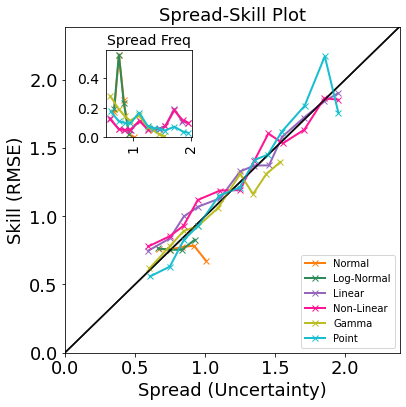

In [298]:
if plotSpreadSkill and pred_test_std is not None:
  n_target = len(DATA_TYPES)
  sDict = {}
  spread_bins = None
  for tg in range(n_target):
    ssDict = {}
    ssDict = get_spread_skill_points(
        y_test[..., tg:tg + 1],
        pred_test_mean[..., tg:tg + 1],
        pred_test_std[..., tg:tg + 1],
        sDict=ssDict,
        spread_bins=spread_bins)
    
    if tg == 0:
      spread_bins = ssDict['ss_spread_bins']
    sDict[tTitle[tg]] = ssDict

  plot_spread_skill_dict(
      sDict, line_label=tTitle,
      plot_hist=True)
  

### PIT Histogram
The probability integral transform (PIT) diagram is useful for regression tasks that predict uncertainty estimates for ensuring that the range of uncertainty is appropriate.  Ideally, the histogram is uniform, indicating that the observed value fall equally into quantiles of the predicted distribution.  If  the histogram has higher values in the center bins, then the observations occur too frequently in the middle of the predicted distribution, so the model uncertainty estimate is too broad and the model is overspread or "underconfident".  If the histogram has high values in the end bins, then the observations occur too often on the outer edges (or even outside) of the predicted uncertainty, indicating the model is underspread or "overconfident".  

#### PIT Helper Functions

In [299]:
def get_pit_points(y_true, y_pred, y_std,
                   pDict={},
                   pit_bins=None):

    if pit_bins is None:
      pit_bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    nTargets = y_true.shape[-1]
    pit_values_all = []
    pit_centers_all = []
    pit_counts_all = []
    pit_weights_all = []
    for tg in range(nTargets):
        pit_values = scipy.stats.norm.cdf(x=y_true[..., tg],
                              loc=y_pred[..., tg],
                              scale=y_std[..., tg]).reshape(-1)
        weights = np.ones_like(pit_values) / pit_values.shape[0]
        pit_counts, bin_centers = get_histogram(pit_values,
                                                bins=pit_bins,
                                                weights=weights)

        pit_values_all.append(pit_values)
        pit_centers_all.append(bin_centers)
        pit_counts_all.append(pit_counts)
        pit_weights_all.append(weights)

    pDict['pit_centers'] = pit_centers_all
    pDict['pit_counts'] = pit_counts_all
    pDict['pit_values'] = pit_values_all
    pDict['pit_weights'] = pit_weights_all
    return pDict

In [300]:
def list_to_str(input_list, format="%.2f"):
    """ Use format="%d" for an integer"""
    return [format % i for i in input_list]

In [301]:
def plot_pit_dict(pDict,
                  bar_color=None,
                  bar_label=None,
                  font_size=14,
                  hline=0.1,
                  legend_show=True,
                  legend_loc='lower right',
                  legend_size=14,
                  save_file='',
                  show_error=True,
                  targetNum=0,
                  title=''):
  
    if bar_color is None:
      bar_color = ['tab:orange', 'seagreen',
                   'tab:purple', 'deeppink',
                   'tab:olive', 'tab:cyan',
                   'tab:brown', 'tab:gray']

    expList = list(pDict.keys())
    nExps = len(expList)

    pit_centers = pDict[expList[0]]['pit_centers'][targetNum]
    pit_labels = list_to_str(pit_centers)
    nBins = len(pit_centers)

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    barWidth = 0.8 / nExps
    r1 = np.arange(nBins) - barWidth * 0.5 * nExps
    eval1 = np.ones(nBins) / 10.

    iExp = 0
    for exp in expList:
        eDict = pDict[exp]
        pit_counts = eDict['pit_counts'][targetNum]
        rNow = [x + barWidth * iExp for x in r1]

        if bar_label is not None:
            barLabel = bar_label[iExp]
            if show_error:
                barLabel += ' (RMSE: {:.3f})'.format(rmse(eval1, pit_counts))
        else:
            barLabel = None

        ax.bar(rNow, pit_counts,
               color=bar_color[iExp],
               edgecolor='black',
               label=barLabel,
               width=barWidth)
        iExp += 1

    if legend_show and bar_label is not None:
        ax.legend(fontsize=legend_size, loc=legend_loc)

    rfinal = np.arange(nBins) - barWidth / 2 * 0.25 * nExps

    if hline is not None:
        xlims = ax.get_xlim()
        ax.plot(xlims, [hline, hline],
                alpha=0.6,
                color='black',
                linestyle='--')
        ax.set_xlim(xlims)

    ax.set_xticks(rfinal, pit_labels)
    ax.set_xlabel("PIT")
    ax.set_ylabel("Probability")
    ax.set_title(title, fontsize=font_size)
    _set_plot_fonts_ax(ax, plotFontSize=font_size)

    if save_file:
        _save_figure(save_file, fig)
    else:
        plt.show()

    plt.close()
    return


#### PIT Plot
Here we show the PIT diagram, with all of the targets shown on a single figure.  The grey dashed line at 0.1 indicates the value that all the PIT bins should be at, and the RMSE shown in the legend is the error from that 0.1 ideal value for each target.

In [302]:
plotPIT = True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


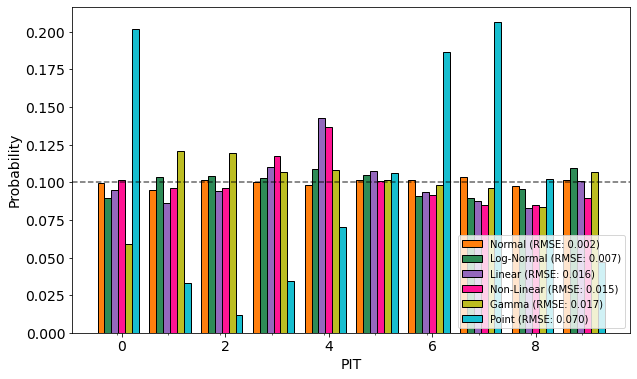

In [303]:
if plotPIT and pred_test_std is not None:
    n_target = len(DATA_TYPES)
    pDict = {}
    for tg in range(n_target):
      eDict = {}
      eDict = get_pit_points(
        y_test[..., tg:tg + 1],
        pred_test_mean[..., tg:tg + 1],
        pred_test_std[..., tg:tg + 1],
        pDict=eDict)
      pDict[tTitle[tg]] = eDict

    plot_pit_dict(pDict, bar_label=tTitle, legend_size=10)

### Discard Test
The discard test shows whether or not the error decreases as the most uncertaint predictions are removed.

#### Discard Helper Functions

In [304]:
def calculate_discard(ytrue, ymean, ystd,
                      bins=None, returnBins=False):
    if bins is None:
        nbins = 10
        bins = np.linspace(0., 0.9, nbins)
    else:
        nbins = len(bins)

    ytrue1d = ytrue.reshape(-1)
    ymean1d = ymean.reshape(-1)
    ystd1d = ystd.reshape(-1)
    nsamples = ystd1d.shape[0]

    yrefs = np.argsort(ystd1d)
    ytrueSorted = ytrue1d[yrefs]
    ymeanSorted = ymean1d[yrefs]

    rmseOut = np.empty((nbins))
    for i in range(nbins):
        iCutoff = nsamples - int(nsamples * bins[i])
        ytrueH = ytrueSorted[:iCutoff]
        ymeanH = ymeanSorted[:iCutoff]
        rmseOut[i] = rmse(ytrueH, ymeanH)

    if returnBins:
        return rmseOut, bins
    else:
        return rmseOut

In [305]:
def get_discard_points(y_true, y_pred, y_std,
                       discardDict={}):

    nTargets = y_true.shape[-1]

    discard_vals_all = []
    discard_bins_all = []
    for tg in range(nTargets):
        discard_vals, discard_bins = calculate_discard(
            y_true[..., tg], y_pred[..., tg],
            y_std[..., tg], returnBins=True)

        discard_vals_all.append(discard_vals)
        discard_bins_all.append(discard_bins)

    discardDict['discard_vals'] = discard_vals_all
    discardDict['discard_bins'] = discard_bins_all
    return discardDict

In [306]:
def plot_discard_dict(discardDict,
                      bar_color=None,
                      bar_label=None,
                      font_size=18,
                      legend_show=True,
                      legend_loc='lower left',
                      legend_size=16,
                      save_file='',
                      targetNum=0,
                      title=''):
  
    if bar_color is None:
      bar_color = ['tab:orange', 'seagreen',
                   'tab:purple', 'deeppink',
                   'tab:olive', 'tab:cyan',
                   'tab:brown', 'tab:gray']
                   
    expList = list(discardDict.keys())
    nExps = len(expList)

    discard_bins = discardDict[expList[0]]['discard_bins'][targetNum]
    discard_labels = list_to_str(discard_bins, format="%.1f")
    nBins = len(discard_labels)

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    barWidth = 0.8 / nExps
    r1 = np.arange(nBins) - barWidth * 0.5 * nExps

    iExp = 0
    for exp in expList:
        eDict = discardDict[exp]
        discard_vals = eDict['discard_vals'][targetNum]
        rNow = [x + barWidth * iExp for x in r1]

        if bar_label is not None:
            barLabel = bar_label[iExp]
        else:
            barLabel = None

        ax.bar(rNow, discard_vals,
               color=bar_color[iExp],
               edgecolor='black',
               label=barLabel,
               width=barWidth)
        iExp += 1

    if legend_show and bar_label is not None:
        ax.legend(fontsize=legend_size, loc=legend_loc)

    rfinal = np.arange(nBins) - barWidth / 2 * 0.25 * nExps

    ax.set_xticks(rfinal, discard_labels)
    ax.set_xlabel("Fraction Removed")
    ax.set_ylabel("RMSE")
    ax.set_title(title, fontsize=font_size)
    _set_plot_fonts_ax(ax, plotFontSize=font_size)

    if save_file:
        _save_figure(save_file, fig)
    else:
        plt.show()

    plt.close()
    return

#### Discard Plot

In [307]:
plotDiscard = True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


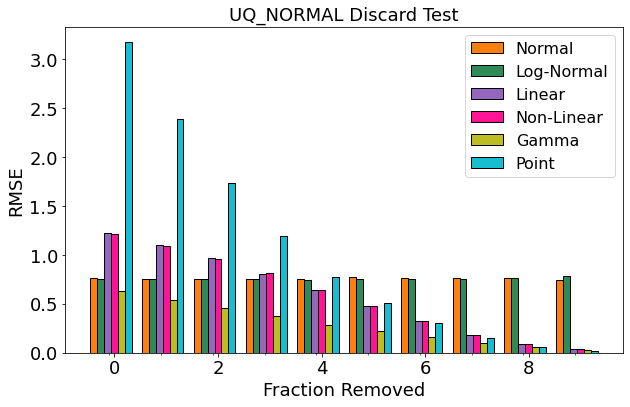

In [308]:
if plotDiscard and pred_test_std is not None:
    n_target = len(DATA_TYPES)
    dDict = {}
    for tg in range(n_target):
      eDict = {}
      eDict = get_discard_points(
        y_test[..., tg:tg + 1],
        pred_test_mean[..., tg:tg + 1],
        pred_test_std[..., tg:tg + 1],
        discardDict=eDict)
      dDict[tTitle[tg]] = eDict

    plot_discard_dict(dDict, bar_label=tTitle, 
                      legend_loc='upper right',
                      title=MODEL_TYPE.upper() + ' Discard Test')